In [22]:
import cv2
import os
import numpy as np
import pickle

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math
import scipy

'''
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc # pip install Pillow
import matplotlib.pylab as pylab

'''

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

# DCT Functions

In [23]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def zigzag(matrix,rows,columns):
    zigzagArray = []
    solution=[[] for i in range(rows+columns-1)] 
  
    for i in range(rows): 
        for j in range(columns): 
            sum=i+j 
            if(sum%2 ==0): 

                #add at beginning 
                solution[sum].insert(0,matrix[i][j]) 
            else: 

                #add at end of the list 
                solution[sum].append(matrix[i][j])
    for i in solution: 
        for j in i:
            zigzagArray.append(j) 
          
    return zigzagArray

# Fiddle with Images

In [24]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 
    
def Crop_Image(img):
    image=Image.open(img)
    image.load()

    image_data = np.asarray(image)
    image_data_bw = image_data.max(axis=2)
    non_empty_columns = np.where(image_data_bw.max(axis=0)>0)[0]
    non_empty_rows = np.where(image_data_bw.max(axis=1)>0)[0]
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

    image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]

    new_image = Image.fromarray(image_data_new)
    return new_image



def Reformat_Image(ImageFilePath):

    from PIL import Image
    image = Image.open(ImageFilePath, 'r')
    image_size = image.size
    width = image_size[0]
    height = image_size[1]


    background = Image.new('RGB', (32, 32), (255, 255, 255))
    offset = (int(round(((32 - width) / 2), 0)), int(round(((32 - height) / 2),0)))

    background.paste(image, offset)
    background = np.asarray(background) 
    return background[:,:,0]

# Get Your Data

In [25]:
def Extract_Images(path):
    Images = []
    labels = []
    th = 128
    for file_name in os.listdir(path):
        for pic in os.listdir(path+"/"+file_name):
                resizedImg = Reformat_Image(path+"/"+file_name+"/"+pic)
                binarizedImg = (resizedImg > th)
                #npImg = npImg.flatten()
                Images.append(binarizedImg)
                labels.append(file_name)
                
    Images = np.asarray(Images)
    labels = np.asarray(labels)
    return Images,labels


def Extract_Features_DCT(Images):
    #show_images([Images[0]],["whatever"])
    Images_Features = []
    for Img_Index in range(Images.shape[0]):
            img = Images[Img_Index]
            imgDCT = dct2(img)
            rows,columns = imgDCT.shape
            array = zigzag(imgDCT,rows,columns)
            feature = array[:150:1]
            Images_Features.append(feature)
    Images_Features = np.asarray(Images_Features)
    return Images_Features


def Extract_Features_Img(Images):
    Images_Features = []
    for Img_Index in range(Images.shape[0]):
            img = Images[Img_Index]
            feature = img.flatten()
            Images_Features.append(feature)
    Images_Features = np.asarray(Images_Features)
    return Images_Features

# Write the File

In [67]:
def Get_Labels(path):
    labels = []
    for file_name in os.listdir(path):
        labels.append(str(file_name))
    labels = np.asarray(labels)
    return labels
        
def Write_File(name,accuracies,labels,spaces):
    accuracies = np.asarray(accuracies)
    with open(name+".txt","w", encoding='utf-8') as file:
        for index_of_letter in range(accuracies.shape[0]):
            max_value = np.amax(accuracies[index_of_letter])
            index_of_max_value = np.where(accuracies[index_of_letter] == max_value)[0][0] # GET THE INDEX OF THE MAXIMUM ELEMNT
            written_letter = labels[index_of_max_value]
            if(index_of_letter != 0):
                if(spaces[index_of_letter] != spaces[index_of_letter - 1]):
                    file.write(" ")
            file.write(written_letter)
            
        
    

# Read the testing data set 

In [80]:
def Read_Test_Data(path):
    letters = []
    spaces = []
    words = 0
    th = 125
    for letter_name in os.listdir(path):
        resizedImg = Reformat_Image(path+"/"+letter_name)
        binarizedImg = (resizedImg > th)
        letters.append(binarizedImg)
        splitted_word = letter_name.split('l')
        number = splitted_word[0][:4]
        spaces.append(number)
    letters = np.asarray(letters)
    spaces = np.asarray(spaces)
    return letters,spaces
        
        

# Train Modules

In [47]:
def Train(names,classifiers,X,y):
    for name, clf in zip(names, classifiers):
        clf = CalibratedClassifierCV(clf)
        print("training classifier",name)
        clf.fit(X, y)
        pickle.dump(clf, open(name, 'wb'))
        #score = clf.score(X_test, y_test)
        #Write_File(name,clf.predict_proba(X_test),data_set_labels)
        #print("Score of classifier",score)
        return


# Test Classifier

In [65]:
def Classifier(model,X_test,data_set_labels,spaces):
    loaded_model = pickle.load(open(model, 'rb'))
    #loaded_model = CalibratedClassifierCV(loaded_model)
    Write_File(model,loaded_model.predict_proba(X_test),data_set_labels,spaces)
    return


# CLassifiers

In [83]:
#h = .02  # step size in the mesh

data_set_labels = Get_Labels("Letters")

names = [#"Nearest Neighbors", "Linear SVM", "RBF SVM",
             "Neural Net"]#, "Naive Bayes"]

classifiers = [
       # KNeighborsClassifier(3),
       # SVC(kernel="linear", C=0.025),
       # SVC(gamma=2, C=1),
        MLPClassifier(alpha=1, max_iter=1000)]
       # , GaussianNB()]


#Training Data 
train_images,train_labels = Extract_Images("Letters")
train_features = Extract_Features_DCT(train_images)
X_train,y_train = train_features,train_labels


Train(names,classifiers,X_train,y_train)

training classifier Neural Net


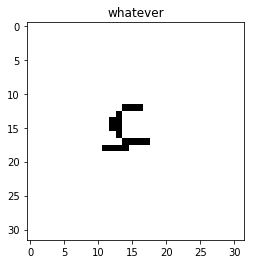

In [84]:
#Test Data 
test_images,spaces = Read_Test_Data("D:\\CMP\\College\\4thYear\\Pattern Recognition\\Project\\Project\\output2")
show_images([test_images[0]],["whatever"])
test_features = Extract_Features_DCT(test_images)
X_test = test_features
Classifier("Neural Net",X_test,Get_Labels("Letters"),spaces)

In [85]:
with open(r'Neural Net.txt', 'r', encoding='utf-8') as infile, \
     open(r'FinalOutput.txt', 'w', encoding='utf-8') as outfile:
    data = infile.read()
    data = data.replace("sss", "س")
    data = data.replace("s","")
    data = data.replace("m","")
    outfile.write(data)

            